In [4]:
import keras
import numpy as np
import tables
from keras.models import Model 
from keras.layers import Input, Dense, BatchNormalization 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [5]:
# 27 features for the jets
# features = ['fj_jetNTracks',
#             'fj_nSV',
#             'fj_tau0_trackEtaRel_0',
#             'fj_tau0_trackEtaRel_1',
#             'fj_tau0_trackEtaRel_2',
#             'fj_tau1_trackEtaRel_0',
#             'fj_tau1_trackEtaRel_1',
#             'fj_tau1_trackEtaRel_2',
#             'fj_tau_flightDistance2dSig_0',
#             'fj_tau_flightDistance2dSig_1',
#             'fj_tau_vertexDeltaR_0',
#             'fj_tau_vertexEnergyRatio_0',
#             'fj_tau_vertexEnergyRatio_1',
#             'fj_tau_vertexMass_0',
#             'fj_tau_vertexMass_1',
#             'fj_trackSip2dSigAboveBottom_0',
#             'fj_trackSip2dSigAboveBottom_1',
#             'fj_trackSip2dSigAboveCharm_0',
#             'fj_trackSipdSig_0',
#             'fj_trackSipdSig_0_0',
#             'fj_trackSipdSig_0_1',
#             'fj_trackSipdSig_1',
#             'fj_trackSipdSig_1_0',
#             'fj_trackSipdSig_1_1',
#             'fj_trackSipdSig_2',
#             'fj_trackSipdSig_3',
#             'fj_z_ratio']


## 45 features for the tracks variables...
features = [
            'trackBTag_DeltaR',
            'trackBTag_Eta',
            'trackBTag_EtaRel',
            'trackBTag_JetDistVal',
            'trackBTag_Momentum',
            'trackBTag_PPar',
            'trackBTag_PParRatio',
            'trackBTag_PtRatio',
            'trackBTag_PtRel',
            'trackBTag_Sip2dVal',
            'trackBTag_Sip2dSig',
            'trackBTag_Sip3dSig',
            'trackBTag_Sip3dVal',
            'track_VTX_ass',
            'track_charge',
            'track_deltaR',
            'track_detadeta',
            'track_dlambdadz',
            'track_dphidphi',
            'track_dphidxy',
            'track_dptdpt',
            'track_dxydxy',
            'track_dxydz',
            'track_dzdz',
            'track_drminsv',
            'track_drsubjet1',
            'track_drsubjet2',
            'track_dxy',
            'track_dxysig',
            'track_dz',
            'track_dzsig',
            'track_erel',
            'track_etarel',
            'track_fromPV',
            'track_isChargedHad',
            'track_isEI',
            'track_isMu',
            'track_lostInnerHits',
            'track_mass',
            'track_normchi2',
            'track_phirel',
            'track_pt',
            'track_ptrel',
            'track_puppiw',
            'track_quality',   
]

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [7]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]
    print(njets)
    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]  ### if 1D variable value for each event in each column.

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    h5file.close()
    return feature_array, label_array

In [8]:
h5file = tables.open_file("/home/kaushik/Documents/thesis work/dataset/ntuple_merged_0.h5", 'r')
# Function to print the structure of the HDF5 file
def print_h5_structure(node, level=0):
    indent = " " * level
    if isinstance(node, tables.Group):
        print(f"{indent}{node._v_name} (Group)")
        for child in node._v_children.values():
            print_h5_structure(child, level + 2)
    else:
        print(f"{indent}{node._v_name} ({type(node).__name__})")

# Start from the root
print_h5_structure(h5file.root)

/ (Group)
  event_no (CArray)
  fj_doubleb (CArray)
  fj_eta (CArray)
  fj_gen_eta (CArray)
  fj_gen_pt (CArray)
  fj_isBB (CArray)
  fj_isH (CArray)
  fj_isNonBB (CArray)
  fj_isQCD (CArray)
  fj_isTop (CArray)
  fj_isW (CArray)
  fj_isZ (CArray)
  fj_jetNTracks (CArray)
  fj_label (CArray)
  fj_labelJMAR (CArray)
  fj_labelLegacy (CArray)
  fj_mass (CArray)
  fj_nSV (CArray)
  fj_n_sdsubjets (CArray)
  fj_nbHadrons (CArray)
  fj_ncHadrons (CArray)
  fj_phi (CArray)
  fj_pt (CArray)
  fj_ptDR (CArray)
  fj_relptdiff (CArray)
  fj_sdmass (CArray)
  fj_sdn2 (CArray)
  fj_sdsj1_axis1 (CArray)
  fj_sdsj1_axis2 (CArray)
  fj_sdsj1_csv (CArray)
  fj_sdsj1_eta (CArray)
  fj_sdsj1_mass (CArray)
  fj_sdsj1_mult (CArray)
  fj_sdsj1_phi (CArray)
  fj_sdsj1_pt (CArray)
  fj_sdsj1_ptD (CArray)
  fj_sdsj2_axis1 (CArray)
  fj_sdsj2_axis2 (CArray)
  fj_sdsj2_csv (CArray)
  fj_sdsj2_eta (CArray)
  fj_sdsj2_mass (CArray)
  fj_sdsj2_mult (CArray)
  fj_sdsj2_phi (CArray)
  fj_sdsj2_pt (CArray)
  fj_sdsj2

In [11]:
data = getattr(h5file.root,"track_phirel")[:]
data.shape

(200000, 60)

In [12]:
feature_array, label_array = get_features_labels('/home/kaushik/Documents/thesis work/dataset/ntuple_merged_0.h5', remove_mass_pt_window=False)
# label_array = np.argmax(label_array, axis=1)
# X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.2, random_state=42)

200000


ValueError: could not broadcast input array from shape (200000,60) into shape (200000,)

<p style="font-family: 'Times New Roman', serif;">
Machine Learning model:
    
   - Gradient Boost Classifier
   - SVM
   - Random Forest Classifier
   - DNN
</p>

In [53]:
gbc = GradientBoostingClassifier()


# Train the final model on the training data
# gbc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")



      Iter       Train Loss   Remaining Time 
         1           0.7226            2.61m
         2           0.6847            2.54m
         3           0.6559            2.49m
         4           0.6338            2.48m
         5           0.6141            2.58m
         6           0.5984            2.56m
         7           0.5845            2.55m
         8           0.5726            2.55m
         9           0.5622            2.57m
        10           0.5525            2.52m
        20           0.5006            2.16m
        30           0.4793            1.86m
        40           0.4679            1.56m
        50           0.4607            1.32m
        60           0.4566            1.06m
        70           0.4531           47.86s
        80           0.4503           32.06s
        90           0.4478           16.09s
       100           0.4454            0.00s
Test set accuracy: 0.9136311630258361


In [56]:
svc = SVC(verbose=True)  # Set verbose=True to print updates during training
# Train the final model on the training data
# svc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

[LibSVM]...........................
*........*...*
optimization finished, #iter = 37697
obj = -30741.247960, rho = -0.759991
nSV = 32464, nBSV = 31029
Total nSV = 32464
Test set accuracy: 0.9058084772370487


In [55]:
rfc = RandomForestClassifier(verbose=1)  # Set verbose=1 to print updates during training

# Train the final model on the training data
# rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   57.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


Test set accuracy: 0.914695474017508


In [15]:
# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 27)]              0         
                                                                 
 bn_1 (BatchNormalization)   (None, 27)                108       
                                                                 
 dense_1 (Dense)             (None, 64)                1792      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 5102 (19.93 KB)
Trainable params: 5048 (19.72 K

2024-07-08 15:30:59.445172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=100, validation_split=0.2, shuffle=False,
                callbacks = callbacks)

Epoch 1/100
147/147 [==============================] - 2s 4ms/step - loss: 0.3070 - accuracy: 0.8853 - val_loss: 0.2486 - val_accuracy: 0.9051
Epoch 2/100
 50/147 [=========>....................] - ETA: 0s - loss: 0.2453 - accuracy: 0.9050

/home/kaushik/miniconda3/envs/my_env_name/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 0s 3ms/step - loss: 0.2422 - accuracy: 0.9066 - val_loss: 0.2386 - val_accuracy: 0.9084
Epoch 3/100
147/147 [==============================] - 1s 4ms/step - loss: 0.2366 - accuracy: 0.9086 - val_loss: 0.2350 - val_accuracy: 0.9101
Epoch 4/100
147/147 [==============================] - 0s 3ms/step - loss: 0.2332 - accuracy: 0.9104 - val_loss: 0.2325 - val_accuracy: 0.9105
Epoch 5/100
147/147 [==============================] - 0s 3ms/step - loss: 0.2307 - accuracy: 0.9114 - val_loss: 0.2308 - val_accuracy: 0.9114
Epoch 6/100
147/147 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9121 - val_loss: 0.2295 - val_accuracy: 0.9117
Epoch 7/100
147/147 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9127 - val_loss: 0.2286 - val_accuracy: 0.9122
Epoch 8/100
147/147 [==============================] - 0s 3ms/step - loss: 0.2260 - accuracy: 0.9132 - val_loss: 0.2279 - val_accuracy: 0.9128
Epoch 9/100

In [17]:
feature_array_test, label_array_test = get_features_labels('/home/kaushik/Documents/thesis work/dataset/ntuple_merged_0.h5')

1969/1969 [==============================] - 2s 1ms/step


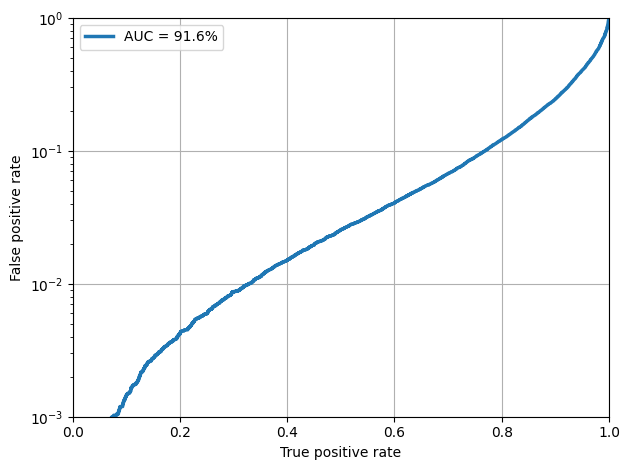

In [18]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')

Done!